# Preprocessing
lucky is in the process of fixing the function

In [64]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np

def calculate_cancer_score(df):
    """
    Calculates a cancer score based on risk factors in the binary encoded data.
    Considers values of 2 (True) as indicators of potential risk.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with one-hot encoded features

    Returns:
        pandas.DataFrame: Original DataFrame with new cancer score and risk category columns
    """

    result_df = df.copy()
    result_df['cancer_score'] = 0

    high_risk_patterns = {
        'age': ['age_60-69', 'age_70-79'],
        'tumor-size': ['tumor-size_25-29', 'tumor-size_30-34', 'tumor-size_35-39',
                       'tumor-size_40-44', 'tumor-size_45-49', 'tumor-size_50-54'],
        'inv-nodes': ['inv-nodes_11-Sep', 'inv-nodes_14-Dec', 'inv-nodes_15-17',
                       'inv-nodes_24-26'],
        'node-caps': ['node-caps_yes'],
        'deg-malig': ['deg-malig']
    }

    for category, patterns in high_risk_patterns.items():
        for pattern in patterns:
            matching_cols = [col for col in df.columns if pattern in col]
            result_df['cancer_score'] += result_df[matching_cols].sum(axis=1)

    max_possible_score = sum(len(patterns) for patterns in high_risk_patterns.values())
    result_df['cancer_score'] = result_df['cancer_score'] / max_possible_score
    cancer_risk = {0: 1, 0.5: 2, 1: 3}
    result_df['cancer_risk'] = result_df['cancer_score'].apply(lambda x: risk_map.get(x, 0))

    return result_df

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np
brecan_df = fetch_ucirepo(id=17) 

X = brecan_df.data.features 
y = brecan_df.data.targets 
  
expected_columns = [
    'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 
    'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1',
    'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 
    'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2',
    'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 
    'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3'
]

columns = [col for col in expected_columns if col in X.columns]
class_labels = LabelEncoder()

brecan_df= pd.get_dummies(X[columns])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# RANDOM FOREST
lucky did this

In [70]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

if 'cancer_risk' in X_train.columns:
    X_train_filtered = X_train.drop(['cancer_risk'], axis=1)
else:
    X_train_filtered = X_train

if 'cancer_risk' in X_test.columns:
    X_test_filtered = X_test.drop(['cancer_risk'], axis=1)
else:
    X_test_filtered = X_test

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_filtered, y_train)
accuracy = rf.score(X_test_filtered, y_test)
print(f"Model Accuracy: {accuracy:.2f}")



c:\Users\19133\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model Accuracy: 0.97


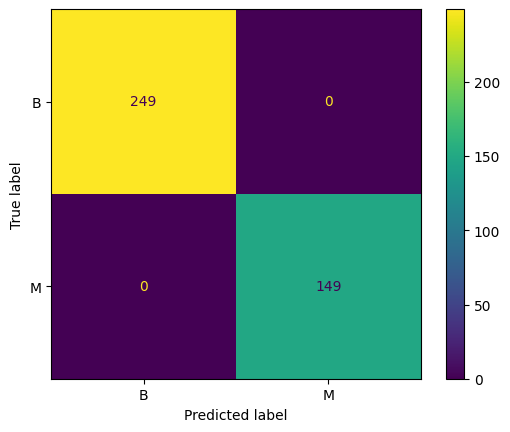

In [71]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, X_train_filtered, y_train)

[0.03231189 0.0110639  0.06009233 0.05381045 0.00622336 0.00921566
 0.08055702 0.14193444 0.00327807 0.00314028 0.01643496 0.00317191
 0.01176976 0.02953842 0.00588079 0.00459638 0.0058159  0.00338232
 0.00400077 0.00713457 0.07797475 0.01878567 0.07429212 0.11821686
 0.01176917 0.01753909 0.04107958 0.12713638 0.01292945 0.00692376] Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3'],
      dtype='object')


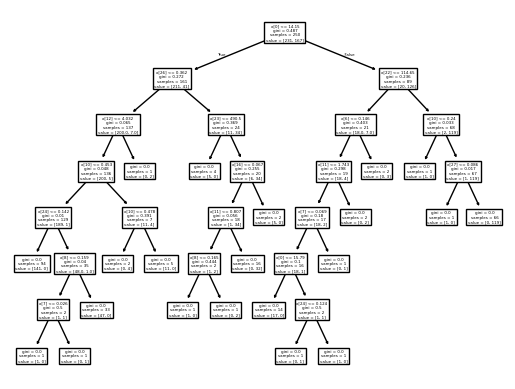

In [73]:
#recall
149/(149+0)
print(rf.feature_importances_, X.columns)
import matplotlib.pyplot as plt
rf_tree = rf.estimators_[7]
tree.plot_tree(rf_tree)
plt.savefig("rf_tree.svg")

# SVC

In [78]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
classifier = make_pipeline(scaler, SVC(gamma='auto'))
classifier.fit(X_train, y_train.to_numpy().ravel())
y_pred_svc = classifier.predict(X_test)

# PCA + Logistic Regression


Explained Variance Ratio:
[0.10985589 0.08103837 0.06704253 0.05542545 0.04546581 0.04314439
 0.04070627 0.0400331  0.0381696  0.03657121 0.03476172 0.03389237
 0.03284144]
0.7325581395348837


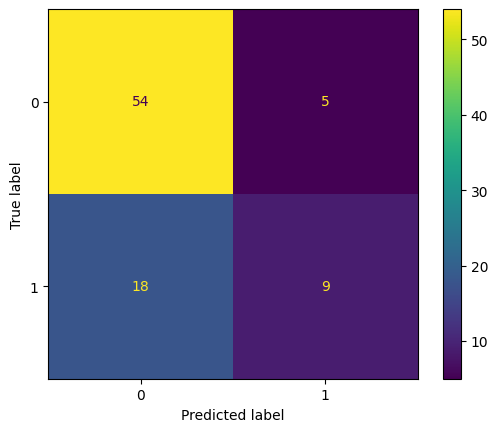

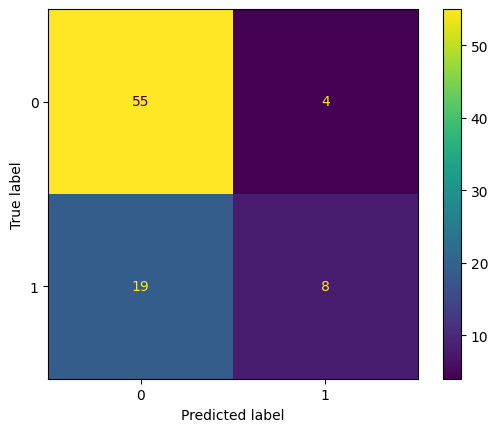

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
#had to do a new split bc old one didn't drop the cancer_score columns

# Encoding categorical columns using LabelEncoder (example: 'High', 'Low' -> 1, 0)
label_encoder = LabelEncoder()
# Assuming the column 'cancer_risk_category' has categorical values that need encoding
X_with_score['cancer_risk'] = label_encoder.fit_transform(X_with_score['cancer_risk'])

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_with_score.drop(['cancer_score', 'cancer_risk'], axis=1, errors='ignore'),
    y_encoded,
    test_size=0.3,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=13)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:")
print(explained_variance)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42).fit(X_train, y_train.ravel())  # Added .ravel() to y_train
y_predicted = model.predict(X_test)

print(model.score(X_test, y_test))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)
model = LogisticRegression(random_state=42).fit(X_train_pca, y_train.ravel())  # Added .ravel() to y_train
model.score(X_test_pca, y_test)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test_pca, y_test)

